In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dataset
import torchvision.utils as util
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
manual_seed = 999
random.seed(manual_seed)
torch.manual_seed(manual_seed)

In [34]:
# config
NUM_WORKERS = 2
BATCH_SIZE = 256
# Spatial size of training images. All images will be resized to this size using a transformer.
IMAGE_SIZE = 64
NUM_CHANNELS = 1
LATENT_VECTOR_SIZE = 100
GENERATOR_FEATURE_MAP_SIZE = 64
DISCRIMINATOR_FEATURE_MAP_SIZE = 64
NUM_EPOCHS = 5
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
NUM_GPUS = 1

In [23]:
dataset = torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    download=True
)

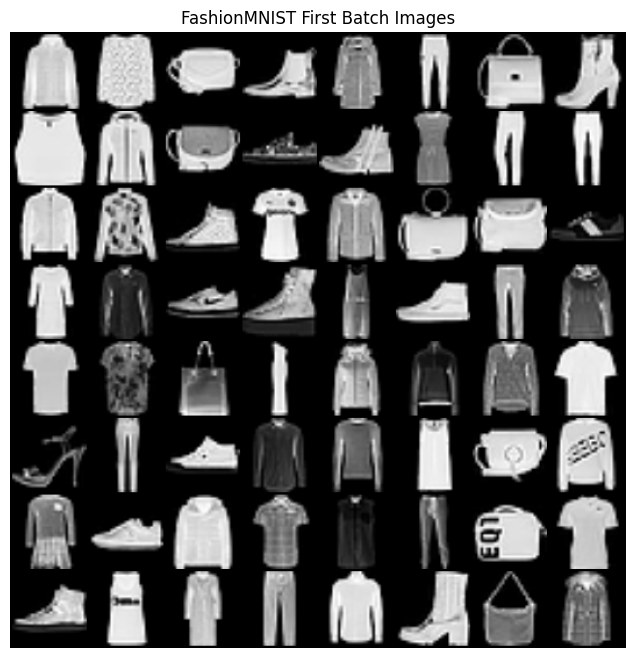

In [24]:
data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

device = torch.device("cuda:0" if torch.cuda.is_available() and NUM_GPUS > 1 else "cpu")

real_batch = next(iter(data_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("FashionMNIST First Batch Images")
plt.imshow(np.transpose(util.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)));

# Weights Initialization

In [25]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find("BatchNorm") != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0.0)

# Generator

In [26]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.model = nn.Sequential(
        nn.ConvTranspose2d(in_channels=LATENT_VECTOR_SIZE, out_channels=GENERATOR_FEATURE_MAP_SIZE * 8, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(GENERATOR_FEATURE_MAP_SIZE * 8),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=GENERATOR_FEATURE_MAP_SIZE * 8, out_channels=GENERATOR_FEATURE_MAP_SIZE * 4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(GENERATOR_FEATURE_MAP_SIZE * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=GENERATOR_FEATURE_MAP_SIZE * 4, out_channels=GENERATOR_FEATURE_MAP_SIZE * 2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(GENERATOR_FEATURE_MAP_SIZE * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=GENERATOR_FEATURE_MAP_SIZE * 2, out_channels=GENERATOR_FEATURE_MAP_SIZE, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(GENERATOR_FEATURE_MAP_SIZE),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=GENERATOR_FEATURE_MAP_SIZE, out_channels=NUM_CHANNELS, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh(),
    )

  def forward(self, input_):
    return self.model(input_)


In [27]:
generator = Generator(NUM_GPUS).to(device)
if device.type == "cuda" and NUM_GPUS > 1:
  generator = nn.DataParallel(generator, list(range(NUM_GPUS)))

generator.apply(weights_init)
generator

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# Discriminator

In [28]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.model = nn.Sequential(
        nn.Conv2d(in_channels=NUM_CHANNELS, out_channels=DISCRIMINATOR_FEATURE_MAP_SIZE, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=DISCRIMINATOR_FEATURE_MAP_SIZE, out_channels=DISCRIMINATOR_FEATURE_MAP_SIZE * 2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(DISCRIMINATOR_FEATURE_MAP_SIZE * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=DISCRIMINATOR_FEATURE_MAP_SIZE * 2, out_channels=DISCRIMINATOR_FEATURE_MAP_SIZE * 4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(DISCRIMINATOR_FEATURE_MAP_SIZE * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=DISCRIMINATOR_FEATURE_MAP_SIZE * 4, out_channels=DISCRIMINATOR_FEATURE_MAP_SIZE * 8, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(DISCRIMINATOR_FEATURE_MAP_SIZE * 8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=DISCRIMINATOR_FEATURE_MAP_SIZE * 8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input_):
    return self.model(input_)

In [29]:
discriminator = Discriminator(NUM_GPUS).to(device)
if device.type == "cuda" and NUM_GPUS > 1:
  discriminator = nn.DataParallel(discriminator, list(range(NUM_GPUS)))

discriminator.apply(weights_init)
discriminator

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

# Training

In [30]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(BATCH_SIZE, LATENT_VECTOR_SIZE, 1, 1, device=device)
real_label = 1.
fake_label = 0.

d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1, 0.999))

In [35]:
img_list = []
g_losses = []
d_losses = []
iters = 0
ones_label = torch.full((BATCH_SIZE, ), real_label,dtype=torch.float, device=device)
zeros_label = torch.full((BATCH_SIZE, ), fake_label,dtype=torch.float, device=device)

print("Starting Training Loop...")
for epoch in range(NUM_EPOCHS):
  for i, data in enumerate(data_loader, 0):
    # Update Discriminator
    discriminator.zero_grad()
    real_cpu = data[0].to(device)
    batch_size = real_cpu.size(0)
    ones_ = ones_label[:batch_size]
    zeros_ = zeros_label[:batch_size]

    output = discriminator(real_cpu).view(-1)
    error_discriminator_real = criterion(output, ones_)
    error_discriminator_real.backward()
    d_x = output.mean().item()

    noise = torch.randn(batch_size, LATENT_VECTOR_SIZE, 1, 1, device=device)
    fake = generator(noise)
    output = discriminator(fake.detach()).view(-1)
    error_discriminator_fake = criterion(output, zeros_)
    error_discriminator_fake.backward()
    d_g_z1 = output.mean().item()

    error_discriminator_total = error_discriminator_real + error_discriminator_fake
    d_optimizer.step()

    # Update Generator
    g_optimizer.zero_grad()
    output = discriminator(fake).view(-1)
    error_generator = criterion(output, ones_)
    error_generator.backward()
    d_g_z2 = output.mean().item()
    g_optimizer.step()

    if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, NUM_EPOCHS, i, len(data_loader),
              error_discriminator_total.item(), error_generator.item(), d_x, d_g_z1, d_g_z2))

    g_losses.append(error_generator.item())
    d_losses.append(error_discriminator_total.item())

    if (iters % 500 == 0) or ((epoch == NUM_EPOCHS-1) and (i == len(data_loader)-1)):
      with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
      img_list.append(util.make_grid(fake, padding=2, normalize=True))

    iters += 1

Starting Training Loop...
[0/5][0/235]	Loss_D: 1.5489	Loss_G: 1.4803	D(x): 0.3122	D(G(z)): 0.0160 / 0.3209
[0/5][50/235]	Loss_D: 0.1898	Loss_G: 2.7804	D(x): 0.9241	D(G(z)): 0.0980 / 0.0811
[0/5][100/235]	Loss_D: 0.6773	Loss_G: 2.7136	D(x): 0.8250	D(G(z)): 0.3351 / 0.0926
[0/5][150/235]	Loss_D: 0.2786	Loss_G: 3.5573	D(x): 0.9353	D(G(z)): 0.1782 / 0.0376
[0/5][200/235]	Loss_D: 0.4671	Loss_G: 3.4661	D(x): 0.8828	D(G(z)): 0.2630 / 0.0424
[1/5][0/235]	Loss_D: 0.2667	Loss_G: 4.3614	D(x): 0.9500	D(G(z)): 0.1787 / 0.0191
[1/5][50/235]	Loss_D: 0.2340	Loss_G: 2.8111	D(x): 0.8644	D(G(z)): 0.0734 / 0.0847
[1/5][100/235]	Loss_D: 0.1863	Loss_G: 2.8915	D(x): 0.8882	D(G(z)): 0.0563 / 0.0753
[1/5][150/235]	Loss_D: 0.3136	Loss_G: 3.3905	D(x): 0.9262	D(G(z)): 0.1954 / 0.0443
[1/5][200/235]	Loss_D: 0.3832	Loss_G: 2.6976	D(x): 0.8599	D(G(z)): 0.1820 / 0.0918
[2/5][0/235]	Loss_D: 0.2263	Loss_G: 3.0348	D(x): 0.8881	D(G(z)): 0.0886 / 0.0667
[2/5][50/235]	Loss_D: 0.3370	Loss_G: 4.0688	D(x): 0.9374	D(G(z)): 0.2

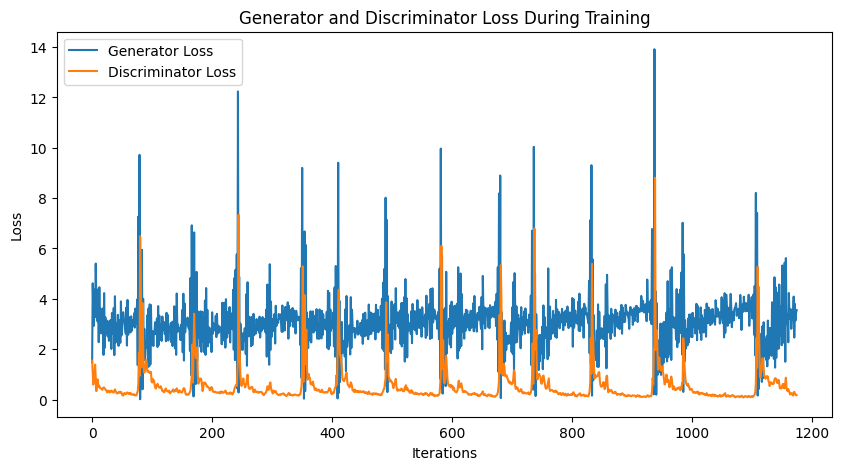

In [36]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

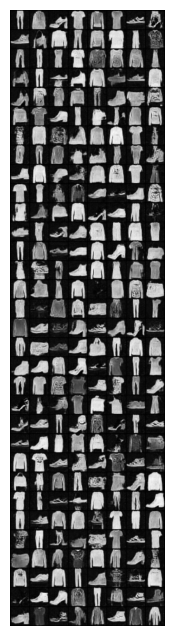

In [37]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

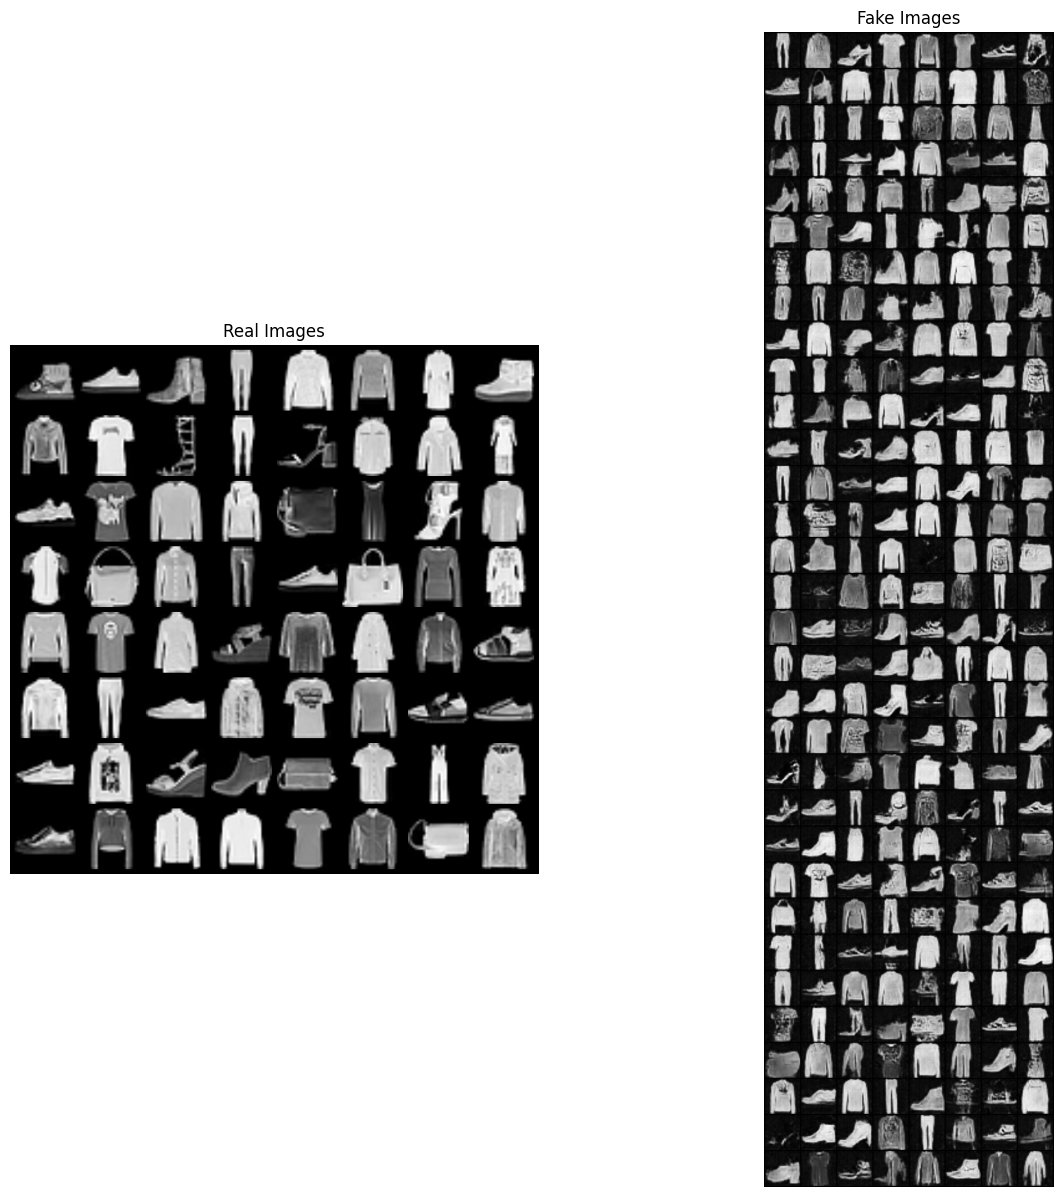

In [38]:
real_batch = next(iter(data_loader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(util.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()